In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.font_manager
from scipy import stats

from scripts import preprocessing as sprocessing
from scripts import clockface_plots as sclockface
from scripts import heatmap_plots as sheatmap
from scripts import config as sconfig
from scripts import utils as sutils
from scripts import dataloaders as sdataloaders
from scripts import similarity_processor as ssimilarity
from scripts import constants as sconstants
from scripts import day_night_comparisons as sday
from scripts.path_utils import *
from scripts.enums import Columns, FactTypes, ContentType, Clusters

# Loading and preprocessing

In [2]:
np.random.seed(0)
config = sconfig.Config(date_from = '2020-01-22')
dl = sdataloaders.APILoader(config)
country_config = sconfig.CountryConfig(LABEL='DEU', TIME_ZONE='Europe/Berlin')
processor = sprocessing.DataProcessor(config)

In [3]:
processor.load_and_prepare(dl, country_config)

DEU in store from 2020-01-22 to 2022-08-01. Store contains ['/ALL', '/DEU', '/ITA', '/ITA_preprocessed', '/NONE'].
Getting DF from Store for the dates 2020-01-22 to 2022-08-01
where_clause:  Datetime >= start_date & Datetime < end_date 
Completed loading DF of size  (18731846, 9)
Converting dateTime
Converting  Columns.YEAR
Converting  Columns.MONTH
Converting  Columns.MIN_BINS15
Finding posts per user


In [4]:
from scripts.path_utils import *
TYPE='all'
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)

In [5]:
activity = activity_path_manager.load('signal')
ratio = ratio_path_manager.load('signal')
activity_smoothed = activity_path_manager.load('fourier')
ratio_smoothed = ratio_path_manager.load('fourier')

In [6]:
all_col = pd.read_parquet(get_cluster_col_path(activity_path_manager))
processor.all[Columns.CLUSTER.value] = all_col

In [7]:
unverified_mask = ~processor.all[Columns.VERIFIED.value]
no_bots_mask = processor.all[Columns.CLUSTER.value] != Clusters.BOT.value
known_mask = processor.all[Columns.FACTTYPE.value]!=FactTypes.OTHER.value.name

In [8]:
type_mask = no_bots_mask

In [9]:
import pickle
with open(get_waking_time_path(config, country_config, TYPE), 'rb') as f:
    waking_times = pickle.load(f)

In [10]:
activity_col=Columns.ACTIVITY_WEIGHTED.value
ratio_col=Columns.RATIO_BY_USER.value

# Corpus, general

Tweets were collected based on keywords and hashtags related to Covid (as described in Gallotti2020). In the following, we only look at Tweets that were classified with a FactType, meaning that they contain a URL in one of the domains in the database by Gallotti2020.
We assume that circadian rhythms have a similar effect on tweets with and without URLS.

In [12]:
t = pd.crosstab(processor.all[Columns.VERIFIED.value], processor.all[Columns.CLUSTER.value], margins=True, dropna=False)
t[[c for c in Clusters]+[c for c in t.columns if c not in list(Clusters)]]

cluster,infrequent type,morning type,intermediate type,evening type,All
verified,,,,,
False,8412670,3374367,1778846,4076858,17642741
True,141506,202030,119151,56959,519646
All,8554176,3576397,1897997,4133817,18162387


In [13]:
18212226-63313

18148913

In [14]:
pd.crosstab(processor.all.loc[no_bots_mask, Columns.VERIFIED.value], processor.all.loc[no_bots_mask, Columns.FACTTYPE.value], margins=True, dropna=False) \
    [[f.value.name for f in FactTypes] + ['All']]

FactType2,Science,Mainstream Media,Satire,Clickbait,Other,Political,Fake or hoax,Conspiracy or junk science,All
verified,,,,,,,,,
False,32946,757190,7706,21902,16637984,120788,44690,19535,17642741
True,447,28110,50,46,481999,8125,836,33,519646
All,33393,785300,7756,21948,17119983,128913,45526,19568,18162387


In [15]:
pd.crosstab(processor.all[Columns.VERIFIED.value], processor.all[Columns.IS_BOT.value], margins=True, dropna=False, normalize=True)

isBot,False,True,All
verified,,,
False,0.539921,0.431468,0.971389
True,0.007199,0.021413,0.028611
All,0.547119,0.452881,1.000000


In [16]:
def get_facttype_stats(df):
    aggr_dict = {Columns.TWEET_ID.value: 'count', Columns.NUM_POSTS.value: ('mean', 'median')}
    facttype_stats= df.groupby(Columns.FACTTYPE.value).agg(aggr_dict)
    facttype_stats = facttype_stats.loc[list(sconstants.FACTTYPE_NAME_MAP.keys())].rename(sconstants.FACTTYPE_MAP, axis=0)
    facttype_stats.loc[ContentType.MANIPULATED.value]=df.groupby(Columns.MACHINATED.value).agg(aggr_dict).loc[True].values
    facttype_stats.columns=['total posts', 'mean posts per author', 'median posts per author']
    facttype_stats.index.name= ''
    return facttype_stats

In [17]:
facttype_stats = get_facttype_stats(processor.all.loc[type_mask])
activity_path_manager.to_latex(facttype_stats.style.format('{:.0f}'), "fact_type_stats.tex", "Statistics for each content type.")
facttype_stats

,total posts,mean posts per author,median posts per author
,,,
Science,33393.0,2356.056269,530.0
Mainstream Media,785300.0,2120.979913,512.0
Satire,7756.0,531.171480,79.0
Clickbait,21948.0,748.880126,41.0
Other,17119983.0,1601.941101,278.0
Political,128913.0,2342.728367,874.0
Fake or hoax,45526.0,3576.943922,1002.0
Conspiracy or junk science,19568.0,2331.128986,698.0
potentially machinated,194007.0,2631.181468,885.0


# All and unverified

In [18]:
by_cluster_verified = sprocessing.group_by_with_total(processor.all.loc[known_mask], group_by_cols=[Columns.VERIFIED, Columns.MACHINATED], total_for_idx=-2)
by_cluster_verified_ft = sprocessing.group_by_with_total(processor.all.loc[known_mask], group_by_cols=[Columns.VERIFIED, Columns.FACTTYPE], total_for_idx=-2)
vmask = lambda df: df.loc[df.index.get_level_values(0).isin([True, False]), [Columns.RATIO_BY_TWEET.value, Columns.RATIO_BY_USER.value]].unstack(level=0)

ratios_by_verified = vmask(by_cluster_verified_ft).loc[FactTypes.known_order(attribute='name')]
ratios_by_verified.loc[ContentType.MANIPULATED.value] = vmask(by_cluster_verified).loc[True]
ratios_by_verified.columns.names=['','']
ratios_by_verified.index.names=['']
ratios_by_verified.rename(columns={Columns.RATIO_BY_TWEET.value:'ratio by Tweet', Columns.RATIO_BY_USER.value:'ratio by user', False: 'unverified', True:'verified'}, inplace=True)

In [19]:
activity_path_manager.to_latex(
    ratios_by_verified.style.format('{:.03f}'),
    'content_type_ratios_by_verified',
    r"Ratios of posts by content type and verification of user.",
    is_multi_index=True)
ratios_by_verified

ratio by Tweet           ratio by user          
                               unverified  verified    unverified  verified
                                                                           
Science                          0.032790  0.011873      0.035107  0.025437
Mainstream Media                 0.753605  0.746673      0.700928  0.879436
Satire                           0.007670  0.001328      0.025981  0.002447
Clickbait                        0.021798  0.001222      0.105513  0.001465
Political                        0.120216  0.215821      0.098975  0.084038
Fake or hoax                     0.044478  0.022206      0.025896  0.006767
Conspiracy or junk science       0.019443  0.000877      0.007600  0.000410
potentially machinated           0.184137  0.238903      0.132472  0.091215

In [20]:
chi2mp=pd.DataFrame(
    index=[Columns.MACHINATED.value, Columns.FACTTYPE.value],
    columns=pd.MultiIndex.from_product((([Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]), ('Chi2', 'P-value'))))
for r in [Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]:
    for df in [by_cluster_verified, by_cluster_verified_ft]:
        ratio_contingency_table=sutils.get_chi2_table(
            df.loc[df.index.get_level_values(0).isin([True, False])],
            ratio_col=r,
            x_col=df.index.names[-1],
            y_col=Columns.VERIFIED.value,
            nr_tries_col=Columns.NUM_POSTS.value)
        chi2mp.loc[df.index.names[-1], r] = stats.chi2_contingency(ratio_contingency_table.round().T)[:2]

In [21]:
chi2mp

ratio_norm                ratio        
                  Chi2 P-value         Chi2 P-value
harmful     542.251584     0.0   718.160303     0.0
FactType2  7257.986068     0.0  5184.124706     0.0

# Inter-cluster variation
## Correlation of user activity with ratio of potentially machinated content

In [23]:
spearman_df = pd.DataFrame(index=list(Clusters), columns=pd.MultiIndex.from_product((
    ['Posts per user', 'Activity per day', 'Fourier smoothed activity per day'],  ['Rho', 'P-Value'])))

by_num_posts_harmful_cluster = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.NUM_POSTS, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2
).xs(True, level=Columns.MACHINATED.value)[ratio_col]

In [24]:
for c in list(Clusters)+['total']:
    rho_t ,p_t = stats.spearmanr((t:=by_num_posts_harmful_cluster.xs(c, level=Columns.CLUSTER.value)).index, t.values)
    rho_ar, p_ar = stats.spearmanr(
        activity.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    rho_ar_smoothed, p_ar_smoothed = stats.spearmanr(
        activity_smoothed.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio_smoothed.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    spearman_df.loc[c] = rho_t, p_t, rho_ar, p_ar, rho_ar_smoothed, p_ar_smoothed


In [25]:
spearman_df

Posts per user           Activity per day            \
                             Rho   P-Value              Rho   P-Value   
infrequent type         0.288061  0.000006        -0.639948       0.0   
morning type           -0.026636  0.349649        -0.659482       0.0   
intermediate type       0.022715  0.502443         0.327442  0.001128   
evening type           -0.054082  0.043196         -0.00506  0.960979   
total                  -0.034735  0.096265        -0.640315       0.0   

                  Fourier smoothed activity per day            
                                                Rho   P-Value  
infrequent type                           -0.821324       0.0  
morning type                              -0.835947       0.0  
intermediate type                          0.753744       0.0  
evening type                               -0.05822  0.573131  
total                                     -0.821663       0.0

In [26]:
activity_path_manager.to_latex(
    spearman_df
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

In [27]:
by_time_facttype_cluster = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER],
    ratio_for_idx=-2
)[ratio_col]

In [28]:
spearman_df_facttype = pd.DataFrame(
    index=pd.MultiIndex.from_product((
        ['Activity per day', 'Fourier smoothed activity per day'], 
        list(Clusters) +['total']
    )),
    columns=pd.MultiIndex.from_product((
        list(FactTypes.harmful_order('name')),  ['Rho', 'P-Value'])
    ))

for c in list(Clusters) +['total']:
    for f in FactTypes.harmful_order('name'):
        rho_ar, p_ar = stats.spearmanr(
            activity.xs(c, level=Columns.CLUSTER.value)[activity_col],
            by_time_facttype_cluster.xs((f, c), level=(Columns.FACTTYPE.value, Columns.CLUSTER.value)))
        rho_ar_smoothed, p_ar_smoothed = stats.spearmanr(
            activity_smoothed.xs(c, level=Columns.CLUSTER.value)[activity_col],
            by_time_facttype_cluster.xs((f, c), level=(Columns.FACTTYPE.value, Columns.CLUSTER.value)))
        spearman_df_facttype.loc[('Activity per day', c), f] = rho_ar, p_ar
        spearman_df_facttype.loc[('Fourier smoothed activity per day', c), f] = rho_ar_smoothed, p_ar_smoothed

In [29]:
spearman_df_facttype

Political            \
                                                          Rho   P-Value   
Activity per day                  infrequent type   -0.407922  0.000037   
                                  morning type      -0.440559  0.000007   
                                  intermediate type  0.152401  0.138252   
                                  evening type       0.008247  0.936436   
                                  total             -0.407773  0.000037   
Fourier smoothed activity per day infrequent type    -0.41248   0.00003   
                                  morning type      -0.411896  0.000031   
                                  intermediate type  0.137344  0.182074   
                                  evening type       0.001574   0.98786   
                                  total             -0.413077  0.000029   

                                                    Fake or hoax            \
                                                             Rho   P-Value   
Activity per day                  infrequent type      -0.623969       0.0   
                                  morning type         -0.524525       0.0   
                                  intermediate type    -0.119533  0.246047   
                                  evening type         -0.044045  0.670031   
                                  total                -0.624349       0.0   
Fourier smoothed activity per day infrequent type      -0.544655       0.0   
                                  morning type          -0.55624       0.0   
                                  intermediate type    -0.126302  0.220119   
                                  evening type         -0.052387  0.612215   
                                  total                -0.544791       0.0   

                                                    Conspiracy or junk science  \
                                                                           Rho   
Activity per day                  infrequent type                     0.064772   
                                  morning type                        -0.15099   
                                  intermediate type                   0.481972   
                                  evening type                        0.062642   
                                  total                               0.064759   
Fourier smoothed activity per day infrequent type                     0.106674   
                                  morning type                       -0.168896   
                                  intermediate type                   0.491142   
                                  evening type                        0.059143   
                                  total                                0.10704   

                                                               
                                                      P-Value  
Activity per day                  infrequent type    0.530672  
                                  morning type       0.141982  
                                  intermediate type  0.000001  
                                  evening type         0.5443  
                                  total              0.530759  
Fourier smoothed activity per day infrequent type    0.300926  
                                  morning type        0.09997  
                                  intermediate type       0.0  
                                  evening type       0.567059  
                                  total               0.29926

In [30]:
activity_path_manager.to_latex(
    spearman_df_facttype
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df_facttype.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_facttype_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's activity level throughout the day with the ratios of politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

## Distances by curve features

If we assume that each chronotype follows similar behavioral patterns but with a time delay depending on their wake-up time, we should see that the curve of their susceptibility over time approaches that of other clusters when aligning the curves by similarity.

We have a few options for aligning by similarity:

We may align by what we estimate is the wake-up time. While we cannot infer the wake-up time per se, we can infer the time when users are usually not asleep, as they are active on Twitter. Therefore, we can estimate that the nadir of their activity is when they are fast asleep.
We consider the user to be asleep within the 8 consecutive hours that they are least active during the day.

Other options are
- the first inflection after the minimum activity (when the slope changes starts getting shallower)
- the first peak after the minimum activity
- the steepest ascent.


## Content types

Do content types differ significantly between clusters?

In [32]:
sp =ssimilarity.SimilarityProcessor(
    activity,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


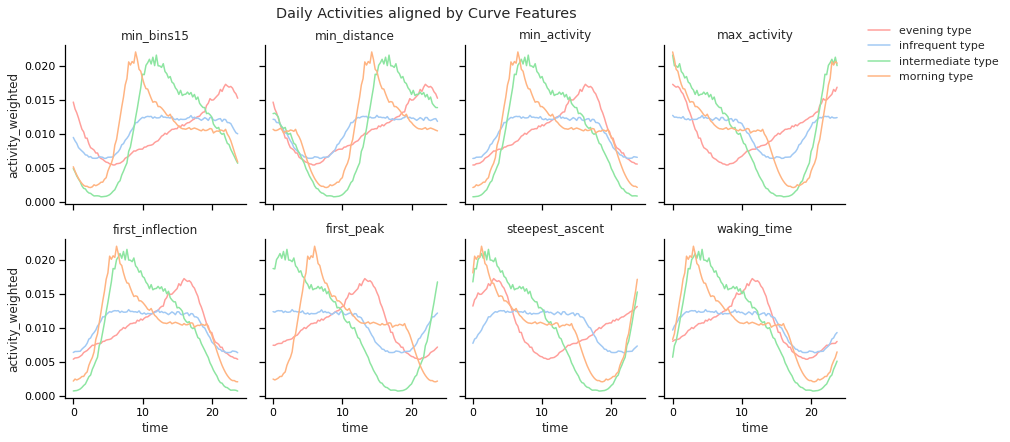

In [33]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4, height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST+['waking_time'])

In [34]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,1.953932e+01,1.106631e-02,1.128000e-01,4.736008e+00,4.593287e-01,2.392337e-03,1.719405e-05
min_activity,1.834882e+01,1.271639e-02,1.369565e-01,5.291089e+00,5.487268e-01,2.857952e-03,2.572758e-05
max_activity,1.740455e+01,1.037914e-02,1.372702e-01,4.410876e+00,5.546722e-01,2.888918e-03,2.259508e-05
first_inflection,1.830880e+01,1.271639e-02,1.369629e-01,5.278501e+00,5.487268e-01,2.857952e-03,2.572758e-05
first_peak,1.778239e+01,1.071069e-02,1.143816e-01,4.797728e+00,4.606399e-01,2.399166e-03,1.918424e-05
steepest_ascent,2.187854e+01,1.009679e-02,1.374279e-01,4.750358e+00,5.576629e-01,2.904494e-03,2.322246e-05
waking_time,2.059820e+01,1.353381e-02,1.473236e-01,5.216225e+00,5.921722e-01,3.084230e-03,2.922061e-05


In [35]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,9.227413e+00,7.484815e-03,7.787382e-02,3.241211e+00,3.132537e-01,1.631530e-03,8.311094e-06
frechet,9.614455e+00,7.081386e-03,8.274358e-02,3.078919e+00,3.330164e-01,1.734460e-03,8.896049e-06
area_between_two_curves,1.226855e+01,8.793623e-03,7.397900e-02,3.511835e+00,2.988921e-01,1.556729e-03,8.258648e-06
curve_length_measure,9.754891e+00,7.529742e-03,8.105407e-02,3.043329e+00,3.262665e-01,1.699305e-03,8.612919e-06
dtw,1.226855e+01,8.793623e-03,7.397900e-02,3.511835e+00,2.988921e-01,1.556729e-03,8.258648e-06
mae,1.226855e+01,8.793623e-03,7.397900e-02,3.511835e+00,2.988921e-01,1.556729e-03,8.258648e-06
mse,9.644093e+00,7.846738e-03,7.545753e-02,3.221127e+00,3.038709e-01,1.582661e-03,8.023632e-06
majority,1.226855e+01,8.793623e-03,7.397900e-02,3.511835e+00,2.988921e-01,1.556729e-03,8.258648e-06


In [36]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
evening type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
infrequent type,-4.75,-4.50,-2.25,-3.50,-2.25,-2.25,-3.00,-2.25
intermediate type,-5.50,-7.25,-4.75,-7.00,-4.75,-4.75,-5.00,-4.75
morning type,-10.50,-10.25,-5.25,-10.00,-5.25,-5.25,-10.00,-5.25


In [37]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

In [38]:
hsp.ratio_similarities.loc['features'].style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,2.566395e+01,1.642686e-01,1.734185e+00,3.228388e+00,7.006441e+00,3.649188e-02,3.308856e-03
min_activity,2.183932e+01,1.894580e-01,1.706809e+00,3.425743e+00,6.913859e+00,3.600968e-02,3.390829e-03
max_activity,2.257386e+01,1.762760e-01,1.711687e+00,3.351471e+00,6.946902e+00,3.618178e-02,3.677445e-03
first_inflection,2.124958e+01,1.894580e-01,1.707378e+00,3.438311e+00,6.913859e+00,3.600968e-02,3.390829e-03
first_peak,1.887699e+01,1.715718e-01,1.709303e+00,3.407564e+00,6.888720e+00,3.587875e-02,3.366827e-03
steepest_ascent,2.921541e+01,1.697375e-01,1.747891e+00,3.525663e+00,7.103469e+00,3.699723e-02,3.758554e-03
waking_time,1.878429e+01,1.778929e-01,1.720562e+00,3.314088e+00,6.928110e+00,3.608391e-02,3.433010e-03


In [39]:
activity_path_manager.to_latex(
    hsp.ratio_similarities.loc['features'].style.highlight_min(props='font-weight:bold', axis=0).format('{:1e}'),
    'similarity_ratio_by_activity',
    r"Distance metrics for the ratio of \harmful{} content when aligned by features of the cluster activity curves. See \cite{Witowski2012ParameterMapping, Frechet1906SurFonctionnel, Jekel2019SimilarityAnalysis,Andrade-Campos2012NovelParameters, Berndt1994UsingSeries} for details on the methods.",
    is_multi_index=False
)

### Smoothed

In [40]:
activity_smoothed.index.names=['min_bins15', 'cluster']

In [41]:
sp = ssimilarity.SimilarityProcessor(
    activity_smoothed,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

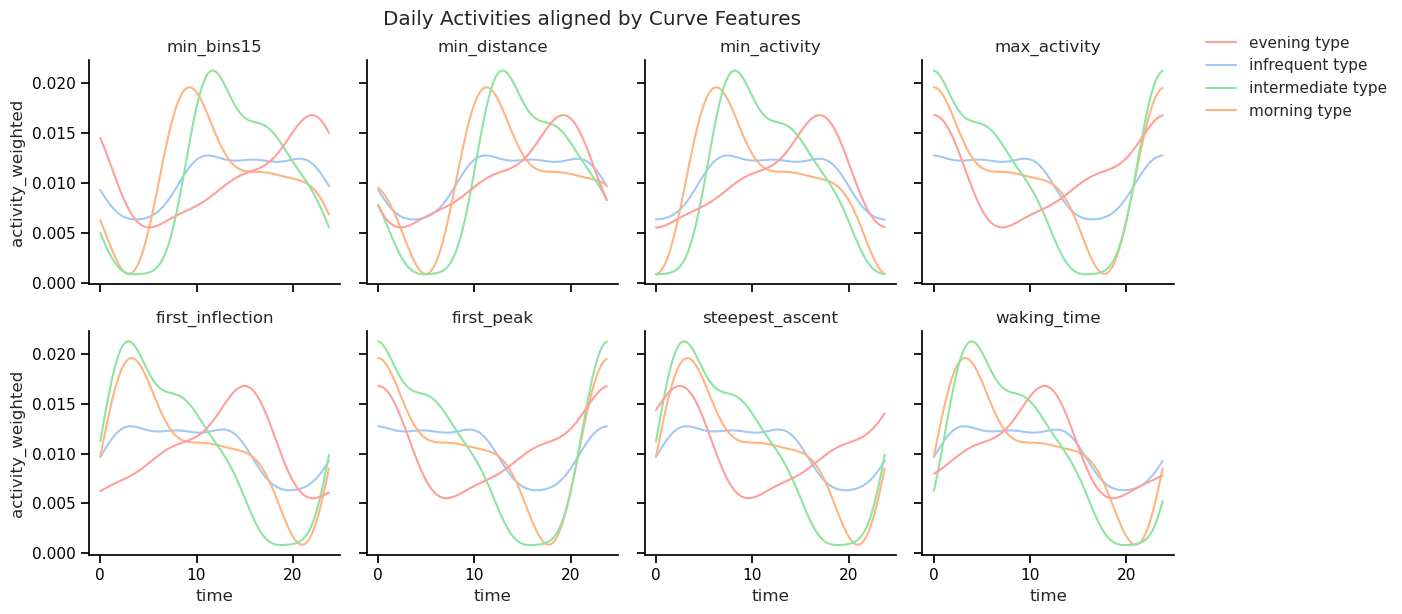

In [42]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4,
                                  height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST + ['waking_time'])

In [43]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,2.6e+01,7.5e-03,8.1e-02,3.2e+00,3.3e-01,1.7e-03,8.1e-06
min_activity,2.9e+01,8.5e-03,8.9e-02,3.1e+00,3.6e-01,1.9e-03,9.7e-06
max_activity,2.1e+01,9.1e-03,1.0e-01,3.8e+00,4.2e-01,2.2e-03,1.3e-05
first_inflection,2.8e+01,8.2e-03,8.5e-02,3.3e+00,3.4e-01,1.8e-03,9.8e-06
first_peak,2.1e+01,9.1e-03,1.0e-01,3.8e+00,4.2e-01,2.2e-03,1.3e-05
steepest_ascent,2.4e+01,9.0e-03,1.0e-01,3.9e+00,4.1e-01,2.2e-03,1.2e-05
waking_time,3.1e+01,9.6e-03,9.9e-02,3.4e+00,4.0e-01,2.1e-03,1.2e-05


In [44]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,2.2e+01,7.9e-03,7.7e-02,3.4e+00,3.1e-01,1.6e-03,8.4e-06
frechet,2.3e+01,6.6e-03,7.1e-02,3.1e+00,2.9e-01,1.5e-03,6.8e-06
area_between_two_curves,2.2e+01,6.8e-03,6.7e-02,3.4e+00,2.7e-01,1.4e-03,6.5e-06
curve_length_measure,2.3e+01,6.8e-03,7.2e-02,3.2e+00,2.9e-01,1.5e-03,7.2e-06
dtw,2.2e+01,6.8e-03,6.7e-02,3.4e+00,2.7e-01,1.4e-03,6.5e-06
mae,2.2e+01,6.8e-03,6.7e-02,3.4e+00,2.7e-01,1.4e-03,6.5e-06
mse,2.1e+01,6.7e-03,6.8e-02,3.4e+00,2.7e-01,1.4e-03,6.4e-06
majority,2.2e+01,6.8e-03,6.7e-02,3.4e+00,2.7e-01,1.4e-03,6.5e-06


In [45]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
infrequent type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
morning type,-5.75,-2.00,-2.00,-3.50,-2.00,-2.00,-2.00,-2.00
intermediate type,-0.50,-23.50,-1.00,-1.25,-1.25,-1.25,-0.25,-1.25
evening type,-20.50,-22.75,-21.00,-22.50,-21.25,-21.25,-21.00,-21.25


In [46]:
ratio_smoothed.index.names=['min_bins15', 'cluster']

In [47]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio_smoothed, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

In [48]:
hsp.ratio_similarities.loc['features'].rename(index=lambda x: 'clock time' if x=="min_bins15" else x.replace("_", " ")).style.highlight_min(color="lightblue", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clock time,2.6e+01,7.8e-02,1.2e+00,3.2e+00,5.0e+00,2.6e-02,1.8e-03
min activity,2.9e+01,8.0e-02,1.2e+00,3.5e+00,5.0e+00,2.6e-02,1.8e-03
max activity,2.2e+01,9.8e-02,1.2e+00,3.6e+00,5.0e+00,2.6e-02,2.2e-03
first inflection,2.3e+01,8.4e-02,1.2e+00,3.3e+00,5.0e+00,2.6e-02,1.8e-03
first peak,2.2e+01,9.8e-02,1.2e+00,3.6e+00,5.0e+00,2.6e-02,2.2e-03
steepest ascent,2.7e+01,9.6e-02,1.2e+00,3.5e+00,5.0e+00,2.6e-02,2.2e-03
waking time,2.3e+01,9.0e-02,1.3e+00,3.2e+00,5.1e+00,2.6e-02,1.9e-03


In [49]:
activity_path_manager.to_latex(
    hsp.ratio_similarities.loc['features']
        .rename(index=lambda x: 'clock time' if x=="min_bins15" else x.replace("_", " "))
        .style.highlight_min(props='font-weight:bold', axis=0).format('{:.1e}'),
    'similarity_ratio_by_activity_fourier',
    r"Distance metrics for the ratio of \harmful{} content when aligned by features of the cluster activity curves. See \cite{Witowski2012ParameterMapping, Frechet1906SurFonctionnel, Jekel2019SimilarityAnalysis,Andrade-Campos2012NovelParameters, Berndt1994UsingSeries} for details on the methods.",
    is_multi_index=False
)

In [51]:
pd.crosstab(processor.all[Columns.CLUSTER.value], processor.all[Columns.FACTTYPE.value], margins=True) \
    .loc[[c for c in Clusters]+['All'], [f.value.name for f in FactTypes] + ['All']].T

cluster,infrequent type,morning type,intermediate type,evening type,All
FactType2,,,,,
Science,12363,7278,3554,10198,33393
Mainstream Media,292657,203593,93435,195615,785300
Satire,5244,954,602,956,7756
Clickbait,15518,2475,1202,2753,21948
Other,8172230,3326246,1764409,3857098,17119983
Political,38859,22229,25658,42167,128913
Fake or hoax,11936,10242,6269,17079,45526
Conspiracy or junk science,5369,3380,2868,7951,19568
All,8554176,3576397,1897997,4133817,18162387


In [52]:
t = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE])

In [53]:
ratio_by_ft_and_cluster_user = t[Columns.RATIO_BY_USER.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_user.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_user.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_user

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.035077,0.030985,0.027484,0.034920
Mainstream Media,0.701471,0.814521,0.773175,0.726860
Satire,0.025917,0.006173,0.007068,0.005322
Clickbait,0.105235,0.013319,0.008675,0.009993
Political,0.098915,0.088167,0.109686,0.139681
Fake or hoax,0.025821,0.032483,0.037062,0.057065
Conspiracy or junk science,0.007565,0.014353,0.036849,0.026158
potentially machinated,0.132300,0.135003,0.183598,0.222904


In [54]:
ratio_by_ft_and_cluster_tweet = t[Columns.RATIO_BY_TWEET.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_tweet.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_tweet.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_tweet

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.032368,0.029094,0.026604,0.036853
Mainstream Media,0.766226,0.813880,0.699427,0.706908
Satire,0.013730,0.003814,0.004506,0.003455
Clickbait,0.040629,0.009894,0.008998,0.009949
Political,0.101740,0.088862,0.192068,0.152382
Fake or hoax,0.031250,0.040943,0.046928,0.061720
Conspiracy or junk science,0.014057,0.013512,0.021469,0.028733
potentially machinated,0.147047,0.143317,0.260465,0.242835


In [55]:
activity_path_manager.to_latex(
    spearman_df
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

In [56]:
activity_path_manager.to_latex(
    ratio_by_ft_and_cluster_user[list(Clusters)].style.format('{:.03f}'),
    'content_type_ratios',
    caption=r"Ratios of posts by content type and cluster. Ratios are negatively weighted by the author's total number of posts.",
    is_multi_index=True
)

### Comparing populations

Evening types post significantly more potentially machinated content than the other clusters, particularly fake or hoax content and politically biased news. Infrequent type users post disproportionately much Clickbait.

In [57]:
by_cluster_h = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.MACHINATED], total_for_idx=-2)

In [58]:
by_cluster_i = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE], total_for_idx=-2)

In [59]:
chi2mp=pd.DataFrame(index=[Columns.MACHINATED.value, Columns.FACTTYPE.value], columns=pd.MultiIndex.from_product((([Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]), ('Chi2', 'P-value'))))
for r in [Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]:
    for df in [by_cluster_h, by_cluster_i]:
        ratio_contingency_table=sutils.get_chi2_table(
            df.loc[list(Clusters)],
            ratio_col=r,
            x_col=df.index.names[-1],
            y_col=Columns.CLUSTER.value,
            nr_tries_col=Columns.NUM_POSTS.value)
        chi2mp.loc[df.index.names[-1], r] = stats.chi2_contingency(ratio_contingency_table.round().iloc[:-1].T)[:2]

In [60]:
chi2mp

ratio_norm                 ratio        
                   Chi2 P-value          Chi2 P-value
harmful     9360.029978     0.0  12936.835769     0.0
FactType2  50579.781481     0.0  23400.276076     0.0

In [61]:
activity_path_manager.to_latex(
    chi2mp.style.format('{:.0f}').format('{:.1e}', subset=[(i, 'P-value') for i in (Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value)]),
    'chi_square',
    caption=r"Chi Square test of difference in distributions in between content types.",
    is_multi_index=True
)

 The p-values are smaller than 0.05 and therefore tells us that the clusters show statistically significant differences in their distributions between content types.
Our null hypothesis (user cluster and spreading of harmful content/content types are independent) can be rejected.

## Diurnal variations

In [62]:
by_cluster_f_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


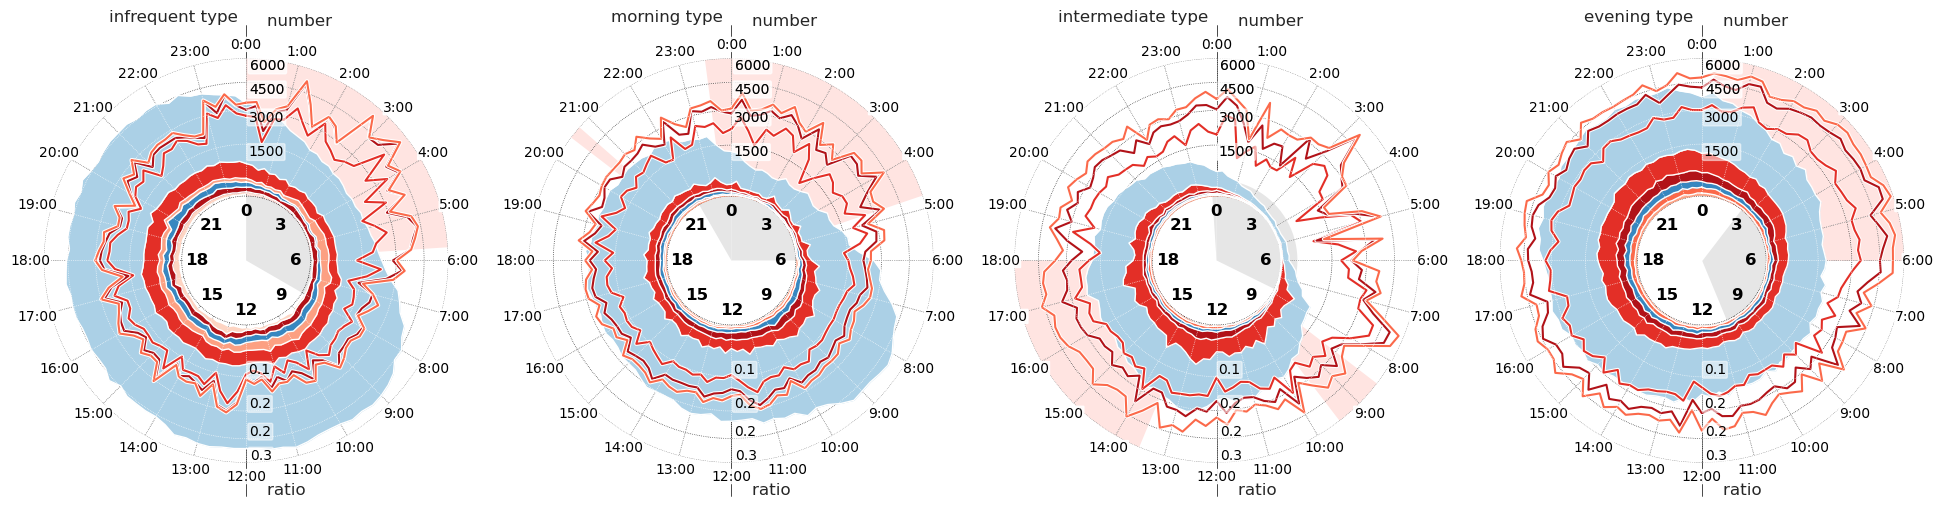

In [63]:
import matplotlib.font_manager
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6,
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not s

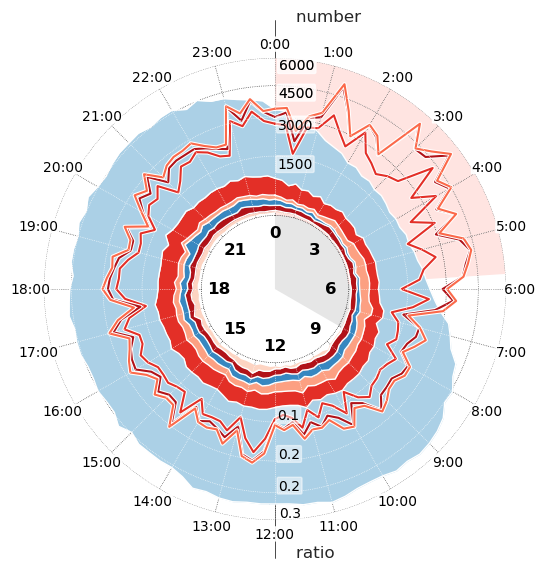

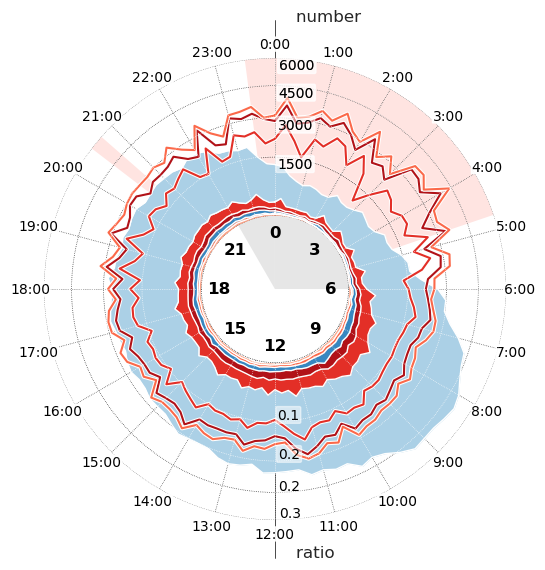

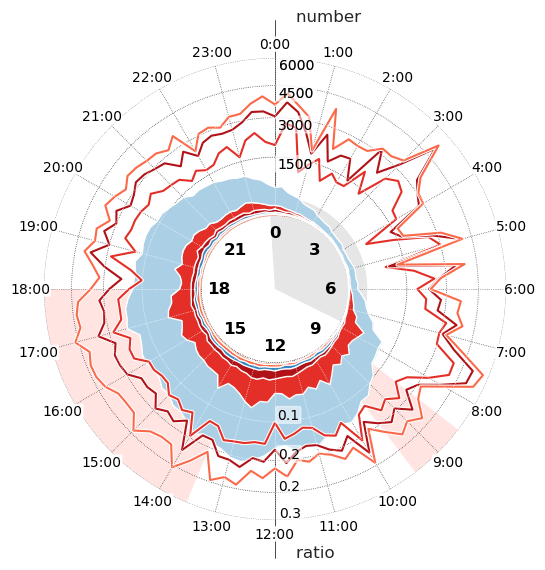

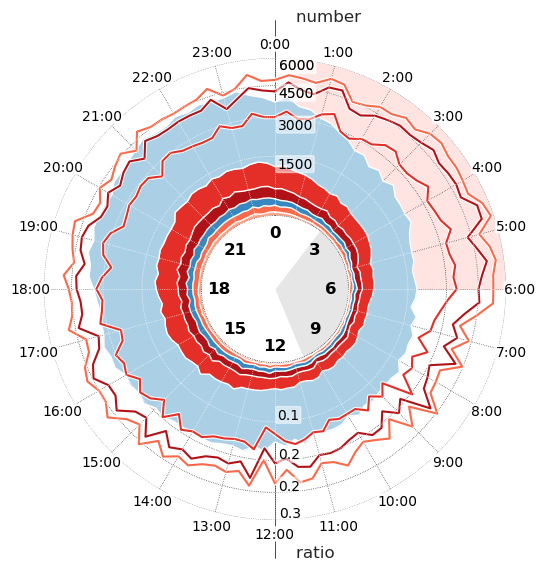

In [64]:
for c in Clusters:
    fig, axes = await sclockface.theme_circle_helper(
        df=by_cluster_f_time.rename(columns={
            Columns.NUM_POSTS.value: "    number",
            Columns.RATIO_BY_USER.value: "    ratio"
        }),
        usecols=["    number"],
        facet_col=Columns.CLUSTER.value,
        hue_col=Columns.FACTTYPE.value,
        palette=FactTypes.palette(),
        susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
        facetorder=[c],
        perline=1,  mul=6,
        waking_times=waking_times,
        susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
        bar_func=sclockface.simple_area_stack,
        line_col=f'    ratio',
        share_h=True,
        project_area=True,
        title=False,
        line_order=[i.value.name for i in FactTypes.harmful_order()])
    fig.savefig(f"{config.SAVE_ROOT_DIR}clockface/{country_config.LABEL}/{c.split()[0]}_{TYPE}.eps", dpi=300, transparent=False)


Above we see:
- as a stackplot: the cumulative number of posts where reliability is known throughout the day, sorted by the  amount of posts of the type throughout the day.
- as a lineplot: with intermittent hatching the  **cumulative ratios** of potentially machinated content types (weighted by 1/num posts per user)
- within the inner shaded grey area: the time when users typically asleep
- within the red shaded background areas the times where the ratio of harmful posts is highest (red, 4th quantile)

Generally, infrequent types have lowest ratios of potentially machinated content types. Evening type individuals post higher baseline rates of potentially machinated content.

In [65]:
by_cluster_f_time_all = sprocessing.group_by_with_total(
    processor.all, group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset


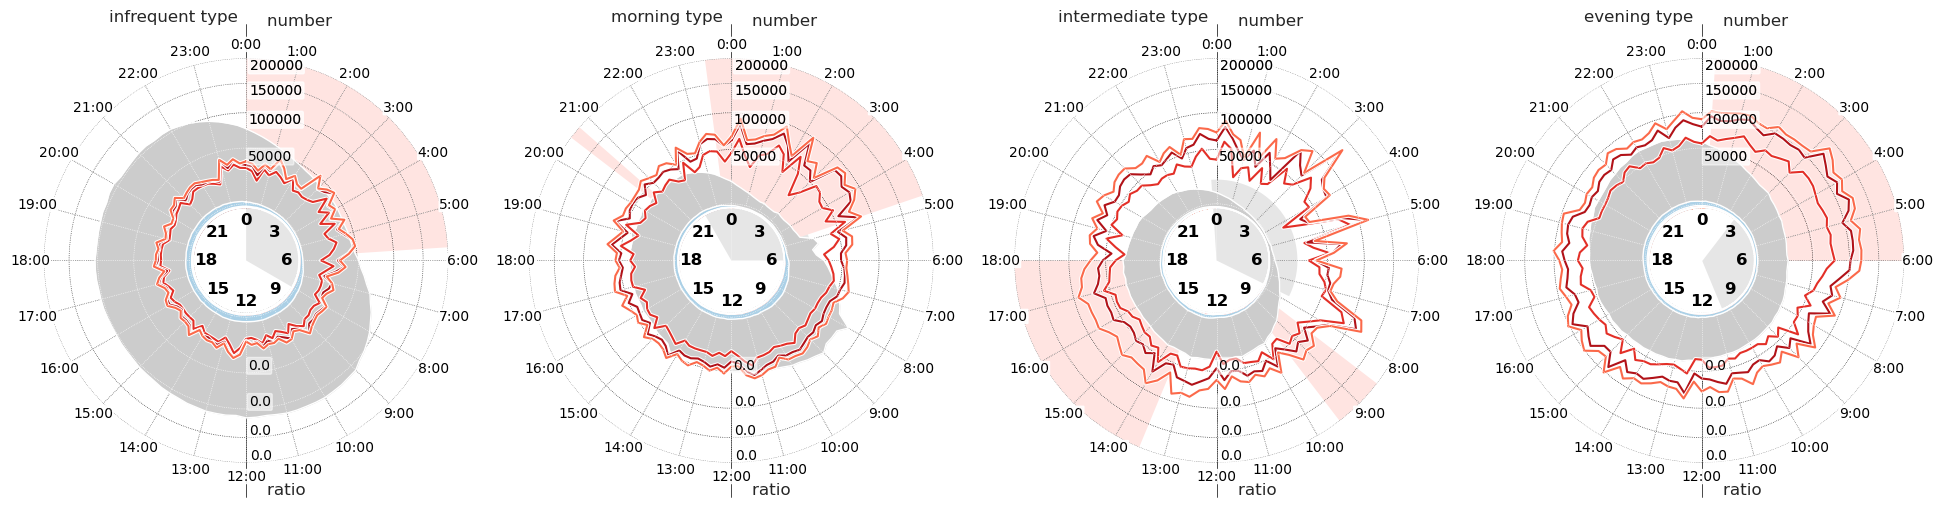

In [66]:
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time_all.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6, # the higher, the smaller font sizes
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])

# Lockdown and harmful content

In [67]:
processor.all[Columns.LOCKDOWN.value] = (('2020-03-09' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2020-05-18'))
# | (('2020-11-05' <= sp.df['local_time']) & (sp.df['local_time'] <= '2020-12-01'))
h_during_lockdown=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.LOCKDOWN, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [68]:
processor.all[Columns.EMERGENCY.value] = (('2020-01-31' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2022-03-31'))
h_during_emergency=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.EMERGENCY, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [69]:
statdf_covid=pd.DataFrame(0, index=list(Clusters)+['total'], columns=pd.MultiIndex.from_product(((Columns.LOCKDOWN.value, Columns.EMERGENCY.value), ['Statistic', 'P-Value'])))

for c in statdf_covid.index:
    tmp_df = h_during_lockdown.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.LOCKDOWN.value), tmp_df.xs(False, level="in_lockdown"), alternative='less')
    statdf_covid.loc[c, Columns.LOCKDOWN.value] = stat,p
    tmp_df = h_during_emergency.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.EMERGENCY.value), tmp_df.xs(False, level="emergency"), alternative='less')
    statdf_covid.loc[c, Columns.EMERGENCY.value] = stat,p

In [70]:
statdf_covid

in_lockdown           emergency          
                    Statistic   P-Value Statistic   P-Value
infrequent type          4371  0.269513      5552  0.992922
morning type             6576  1.000000      6627  1.000000
intermediate type        3177  0.000148      4481  0.418591
evening type             5370  0.976178      6496  1.000000
total                    4371  0.269513      5552  0.992922

In [71]:
lockdown_df = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.CLUSTER, Columns.MACHINATED, Columns.LOCKDOWN],
    total_for_idx=0,
    ratio_for_idx=1)

In [72]:
users_per_cluster = processor.all.loc[type_mask & known_mask].groupby([Columns.CLUSTER.value])[Columns.USER.value].nunique()
users_per_cluster['total']=users_per_cluster.sum()
users_per_cluster

cluster
evening type           4558
infrequent type      142177
intermediate type      2216
morning type           4072
total                153023
Name: User, dtype: int64

In [73]:
lockdown_days= { 
    True: len(processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique()),
    False: len(processor.all.loc[type_mask & known_mask & ~(processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique())
}
def posts_per_day(x, row, num_users=None):
    cluster, lockdown = row.name
    return row[x]/lockdown_days[lockdown]/(1 if num_users is None else num_users[cluster])

In [74]:
lockdown_stat_df = (lockdown_df
    .loc[lockdown_df.index.get_level_values(level=Columns.LOCKDOWN.value)!="total"]
    .xs(True, level=Columns.MACHINATED.value)[[Columns.RATIO_BY_USER.value, Columns.NUM_POSTS.value]])
lockdown_stat_df['num_posts_total'] = num_posts_by_lockdown=lockdown_df.groupby(level=[Columns.CLUSTER.value, Columns.LOCKDOWN.value])[Columns.NUM_POSTS.value].sum()
lockdown_stat_df["posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day(Columns.NUM_POSTS.value, row, users_per_cluster), axis=1)
lockdown_stat_df["harmful_posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day('num_posts_total', row, users_per_cluster), axis=1)
lockdown_stat_df = lockdown_stat_df[[Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']].unstack(level=1)
for i in [Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']:
    lockdown_stat_df[i, 'diff']= lockdown_stat_df[i, True] - lockdown_stat_df[i, False]
lockdown_stat_df.sort_index(axis=1, inplace=True)
lockdown_stat_df.columns=pd.MultiIndex.from_product(((f'{ContentType.MANIPULATED.value} posts/day/user','posts/day/user', f'ratio of {ContentType.MANIPULATED.value} content'),('no lockdown', 'lockdown', 'change')))
lockdown_stat_df.index.name=None
lockdown_stat_df.T

evening type  \
potentially machinated posts/day/user   no lockdown      0.064931   
                                        lockdown         0.102034   
                                        change           0.037103   
posts/day/user                          no lockdown      0.015708   
                                        lockdown         0.025478   
                                        change           0.009770   
ratio of potentially machinated content no lockdown      0.221401   
                                        lockdown         0.233373   
                                        change           0.011972   

                                                     infrequent type  \
potentially machinated posts/day/user   no lockdown         0.002741   
                                        lockdown            0.006074   
                                        change              0.003334   
posts/day/user                          no lockdown         0.000404   
                                        lockdown            0.000878   
                                        change              0.000474   
ratio of potentially machinated content no lockdown         0.132769   
                                        lockdown            0.129838   
                                        change             -0.002931   

                                                     intermediate type  \
potentially machinated posts/day/user   no lockdown           0.064068   
                                        lockdown              0.106099   
                                        change                0.042030   
posts/day/user                          no lockdown           0.016256   
                                        lockdown              0.032723   
                                        change                0.016467   
ratio of potentially machinated content no lockdown           0.186871   
                                        lockdown              0.160250   
                                        change               -0.026621   

                                                     morning type     total  
potentially machinated posts/day/user   no lockdown      0.064658  0.007129  
                                        lockdown         0.115556  0.013295  
                                        change           0.050897  0.006166  
posts/day/user                          no lockdown      0.008922  0.001316  
                                        lockdown         0.020622  0.002597  
                                        change           0.011700  0.001281  
ratio of potentially machinated content no lockdown      0.131228  0.132803  
                                        lockdown         0.155050  0.129872  
                                        change           0.023822 -0.002931

In [75]:
lockdown_contingency=processor.all.loc[type_mask & known_mask].groupby([Columns.MACHINATED.value, Columns.LOCKDOWN.value])[Columns.TWEET_ID.value].count().unstack(level=1)

In [76]:
stats.chi2_contingency(lockdown_contingency)

(92.9343471598004,
 5.405815674441609e-22,
 1,
 array([[732494.8898949, 115902.1101051],
        [167503.1101051,  26503.8898949]]))

In [77]:
activity_path_manager.to_latex(
    lockdown_stat_df.T[list(Clusters)].style.format('{:.3f}', na_rep="-"),
    'stats_lockdown',
    caption=r"Number of posts and ratio of harmful content during and outside of the lockdown period.",
    is_multi_index=True
)

# Sunlight impacts a user's spreading of disinformation

In [11]:
m_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1,
    aggregate_cols=[Columns.LAT, Columns.LONG]
)

In [12]:
df_monthly = m_over_time.xs('total', level=Columns.CLUSTER.value)

In [13]:
from suntime import Sun
import datetime, pytz, math

lat = df_monthly[Columns.LAT.value].mean()
long = df_monthly[Columns.LONG.value].mean()
sun = Sun(lat, long)
tz = pytz.timezone(country_config.TIME_ZONE)

def to_bin(timeobj):
    timeobj = timeobj.time()
    return (((timeobj.hour*3600)+(timeobj.minute*60))//900)*0.25


sun_times = {}
for i in range(1,13):
    date = datetime.date(2020, i, 1)
    sunrise = sun.get_local_sunrise_time(date, local_time_zone=tz)
    sun_times[i] = {
        "sunrise":  to_bin(sun.get_local_sunrise_time(date, local_time_zone=tz)),
        "sunset":  to_bin(sun.get_local_sunset_time(date, local_time_zone=tz))
    }

sun_times = pd.DataFrame.from_dict(sun_times, orient='index')
years_spanned = math.ceil(np.ptp(processor.all.loc[type_mask, Columns.LOCAL_TIME.value]).days/365)
sun_times_total = pd.concat([sun_times for _ in range(years_spanned)]).reset_index(drop=True)
daytimes=round(sun_times_total.mean()*4)/4

In [14]:
daytimes

sunrise     6.75
sunset     19.00
dtype: float64

In [15]:
palette=["lightblue", "coral", "darkred"]
cmap=sns.color_palette("blend:"+",".join(palette), as_cmap=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


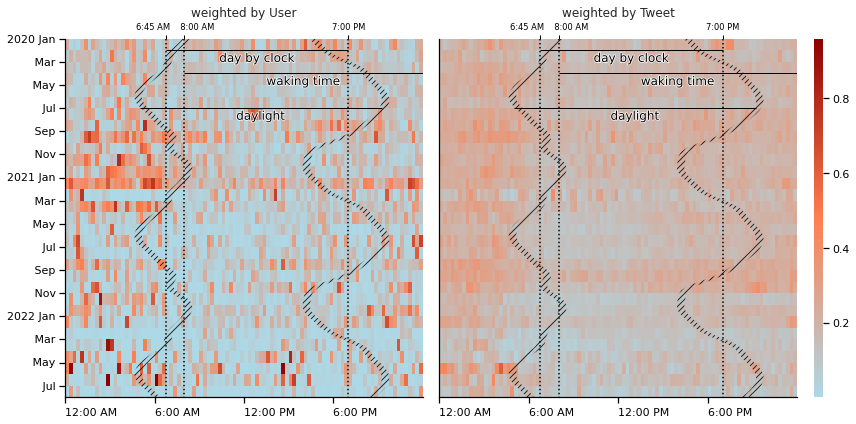

In [16]:
import matplotlib.font_manager
cols=[Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]
sheatmap.plot_heatmap_facets(
    m_over_time.xs((True, 'total'), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[cols],
    sun_times=sun_times_total, waking_times={c: waking_times['total'] for c in cols}, day_times=daytimes,
    columns=cols, subtitles=["weighted by User", "weighted by Tweet"], figsize=(12,6), cmap=cmap, edgecolor="black");

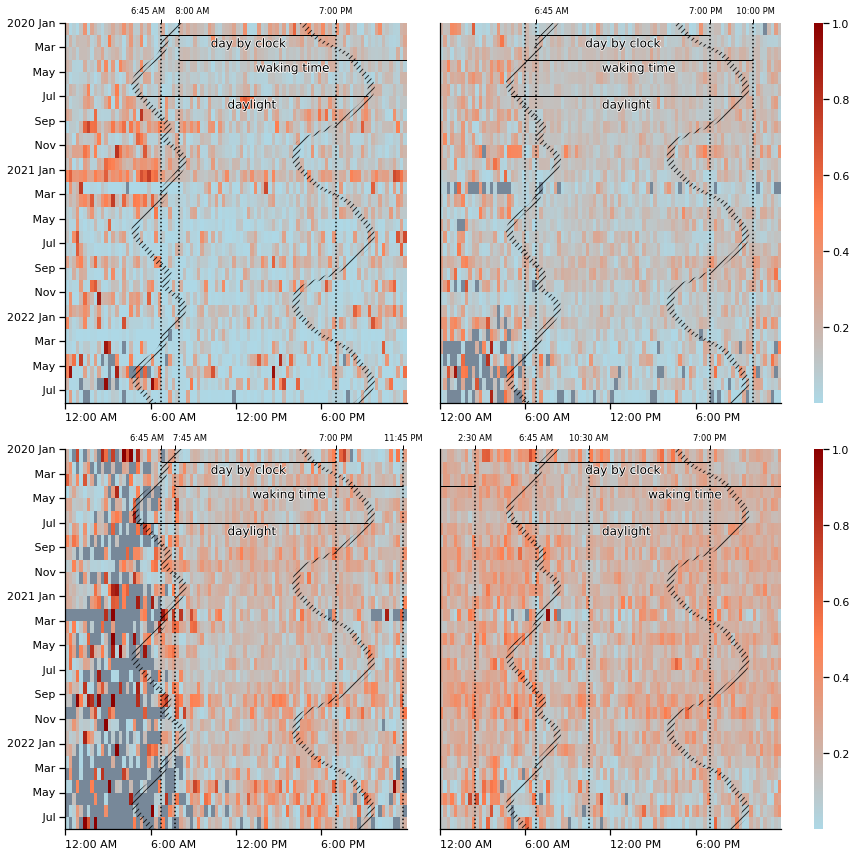

In [17]:
fig, axes = sheatmap.plot_heatmap_facets(
    m_over_time.xs(True, level=Columns.MACHINATED.value)[Columns.RATIO_BY_USER.value].unstack(level=Columns.CLUSTER.value),
    sun_times=sun_times_total, waking_times={i:waking_times[i] for i in Clusters}, day_times=daytimes,
    columns=list(Clusters), subtitles = [],
    figsize=(12,12), cmap=cmap, facecolor='lightslategrey', nrows=2, ncols=2, edgecolor="black")

In [18]:
bbox_for_cluster = {
    # left, bottom, right, top
    'infrequent': (0,6,6,12),
    'morning': (6,6,12,12),
    'intermediate': (0,0,6,6),
    'evening': (6,0,12,6)
}
for c, b in bbox_for_cluster.items():
    fig.savefig(f"{config.SAVE_ROOT_DIR}heatmap/{country_config.LABEL}/{c}_{TYPE}.eps", dpi=300, transparent=False, bbox_inches=mpl.transforms.Bbox.from_extents(b))

### By FactType

In [19]:
f_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1
)

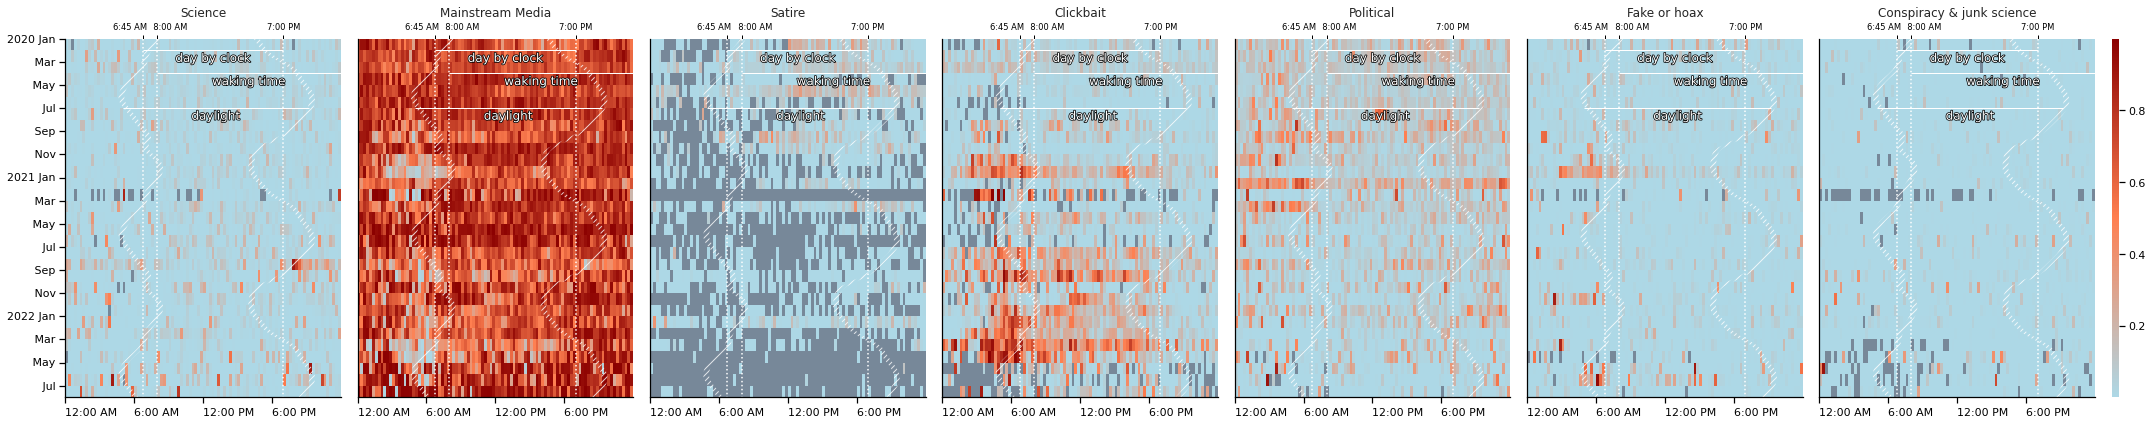

In [20]:
import matplotlib.font_manager
fig, axes = sheatmap.plot_heatmap_facets(
    f_over_time.xs('total', level=Columns.CLUSTER.value)['ratio_norm'].unstack(level=sconstants.f_col),
    sun_times=sun_times_total, waking_times={i:waking_times['total'] for i in FactTypes.known_order('name')}, day_times=daytimes,
    columns=FactTypes.known_order('name'), subtitles = FactTypes.known_order('name'),
    figsize=(30,6), cmap=cmap, facecolor='lightslategrey', nrows=1, ncols=7)

### Statistics

In [21]:
sday.get_waking_time(m_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))
sday.get_waking_time(f_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))

In [22]:
for c in Clusters:
    tmpdf=m_over_time.xs((True, c), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[Columns.RATIO_BY_USER.value]
    print(f'{c}: {stats.shapiro(tmpdf)}')

infrequent type: ShapiroResult(statistic=0.8114676475524902, pvalue=0.0)
morning type: ShapiroResult(statistic=0.8852375149726868, pvalue=7.380639011598812e-42)
intermediate type: ShapiroResult(statistic=0.8446864485740662, pvalue=9.80908925027372e-45)
evening type: ShapiroResult(statistic=0.9734317660331726, pvalue=4.607373671379528e-23)


Our data is not normally distributed.

In [23]:
shared_args = {
    'ratio_col': Columns.RATIO_BY_USER.value,
    'test': stats.mannwhitneyu,
}
m_stat_df = sday.pair_cols(m_over_time, Columns.MACHINATED.value, ivals=[True], **shared_args)
f_stat_df = sday.pair_cols(f_over_time, Columns.FACTTYPE.value, ivals=FactTypes.harmful_order('name'), **shared_args)

Find which distribution was lower (day or night) only for those values where p was significant:

In [24]:
threshold=.05
stat_df = pd.concat([
        sday.find_distribution_side(m_stat_df, threshold=threshold).rename(index={True: ContentType.MANIPULATED.value}),
        sday.find_distribution_side(f_stat_df, threshold=threshold).loc[FactTypes.harmful_order('name')]
    ])

In [27]:
stat_df_style =(
    stat_df.loc[stat_df.index.get_level_values(1).isin(list(Clusters))]
    .rename(columns={
        'daytime': r'6:30am - 6:45pm\tnote{1}',
        'suntime': r'sunrise - sunset\tnote{2}',
        'waking_time': r'waking - bedtime\tnote{3}'
    })
    .style
    .format('{:,.0f}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "Statistic"]])
    .format('{:.1e}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
    .applymap(
        lambda v: 'font-weight: bold;' if (v < 0.05) else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
)
stat_df_style

In [26]:
activity_path_manager.to_latex(
    stat_df_style,
    'mannwhitneyu_daysunwaking',
    caption=r"One-sided Mann-Whitney U test indicating whether the distribution of ratios of \harmful{} content throughout the day (see \autoref{fig:fourier_activity_clocktime}) underlying one cluster (rows) is smaller than that of another cluster (columns).",
    is_multi_index=True
)